Sensor-frame MSE (X, Y, Z): ['0.7801', '0.1340', '0.7982']
World-frame  MSE (X, Y, Z): ['0.1852', '0.4848', '1.0422']


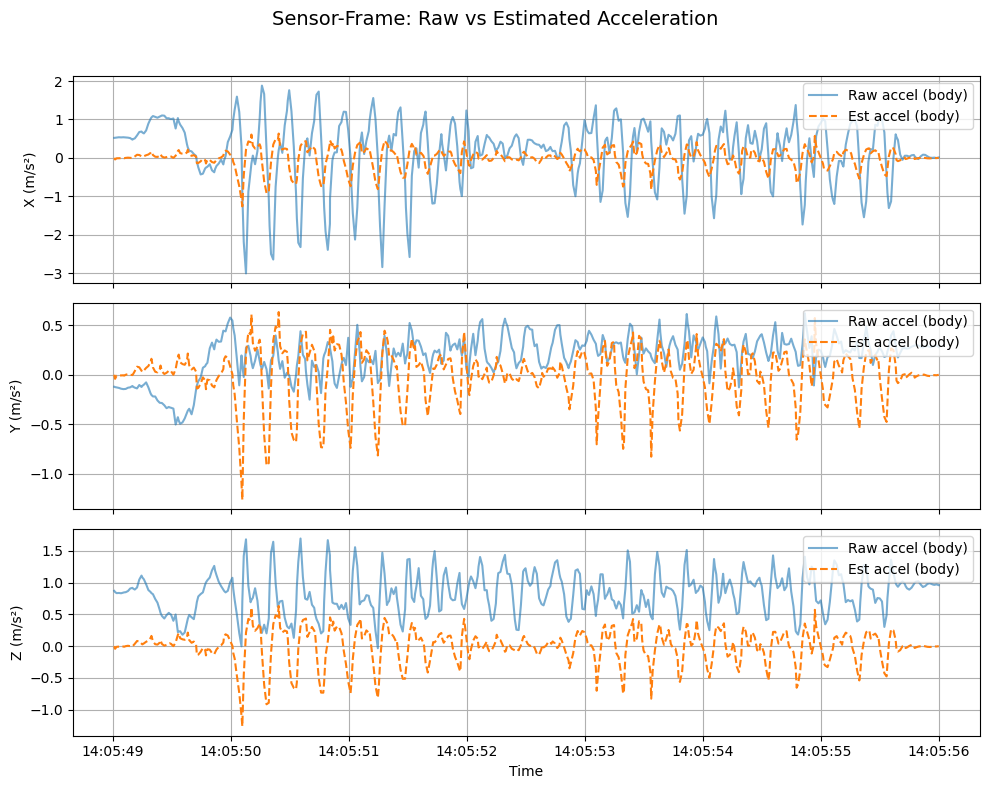

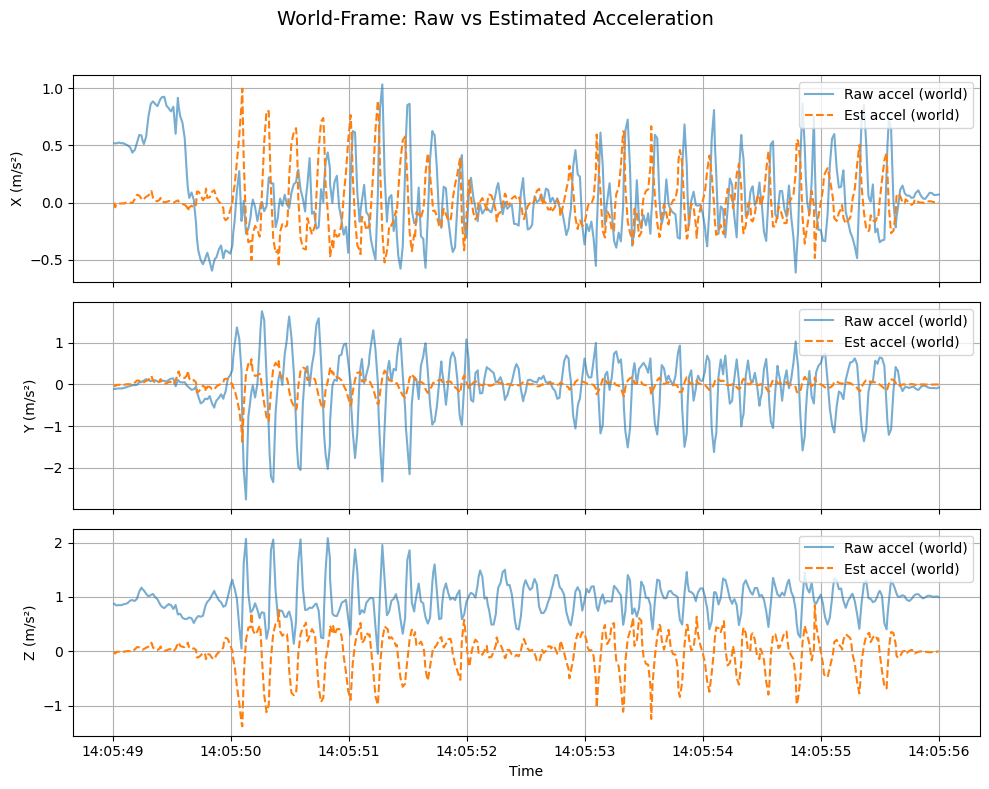

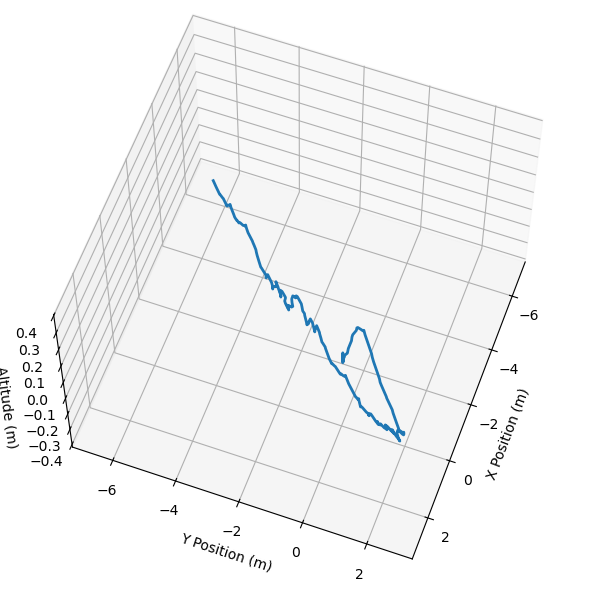

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D
from ahrs.filters import Mahony

# --- UTILITY FUNCTIONS ---
def quaternion_conjugate(q):
    return np.array([q[0], -q[1], -q[2], -q[3]])

def quaternion_multiply(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    return np.array([
        w1*w2 - x1*x2 - y1*y2 - z1*z2,
        w1*x2 + x1*w2 + y1*z2 - z1*y2,
        w1*y2 - x1*z2 + y1*w2 + z1*x2,
        w1*z2 + x1*y2 - y1*x2 + z1*w2
    ])

def quaternion_rotate(q, v):
    """Rotate 3-vector v by quaternion q (w, x, y, z)."""
    qv = np.concatenate([[0.0], v])
    return quaternion_multiply(
        quaternion_multiply(q, qv),
        quaternion_conjugate(q)
    )[1:]

def pressure_to_altitude(p, p0):
    """Barometric formula: altitude above reference p0."""
    return 44330.0 * (1.0 - (p / p0)**(1/5.255))


# --- USER CONFIGURATION ---
csv_path   = '/Users/benjaminli/Code/Industrial_Project/S_82924/PANORAMIC_RIGHT_all_sensors.csv'
start_time = '2024-05-17 14:05:49'
end_time   = '2024-05-17 14:05:56'

# HPF cutoff and Mahony gains
fc  = 0.01
Kp  = 1.0
Ki  = 0.1
tau = 1.0 / (2.0 * np.pi * fc)

# --- 1) Load & filter ---
df = pd.read_csv(csv_path)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)
df = df.interpolate(method='linear', limit_direction='both')
df = df.dropna(subset=[
    'GYRO_x','GYRO_y','GYRO_z',
    'HE_ACC_x','HE_ACC_y','HE_ACC_z',
    'MAGNETIC_FIELD_x','MAGNETIC_FIELD_y','MAGNETIC_FIELD_z',
    'PRESSURE'
]).reset_index(drop=True)

mask = (
    (df['timestamp'] >= pd.to_datetime(start_time)) &
    (df['timestamp'] <= pd.to_datetime(end_time))
)
df = df.loc[mask].reset_index(drop=True)
N = len(df)
if N < 3:
    raise ValueError("Need at least 3 samples to estimate second derivative.")

# --- 2) Prep storage & filter ---
q_arr    = np.zeros((N, 4))
mahony   = Mahony(Kp=Kp, Ki=Ki, sampleperiod=0.01)

acc_hp   = np.zeros((N, 3))
pos      = np.zeros((N, 3))
alt      = np.zeros(N)

# reference pressure
p0 = df.loc[0, 'PRESSURE']

# init from sample 0
row0     = df.loc[0]
gyro0    = np.array([row0.GYRO_x, row0.GYRO_y, row0.GYRO_z]) * np.pi/180.0
acc0     = np.array([row0.HE_ACC_x, row0.HE_ACC_y, row0.HE_ACC_z])
mag0     = np.array([row0.MAGNETIC_FIELD_x,
                     row0.MAGNETIC_FIELD_y,
                     row0.MAGNETIC_FIELD_z])

# initial quaternion
q = np.array([1.0, 0.0, 0.0, 0.0])
q = mahony.updateMARG(q, gyr=gyro0, acc=acc0, mag=mag0)
q_arr[0] = q

# compute initial gravity-removed accel & HPF seed
g0        = quaternion_rotate(q, np.array([0,0,9.81]))
a_lin0    = acc0 - g0
acc_hp[0] = np.zeros(3)
prev_acc_lin = a_lin0.copy()

# initial pos & alt
pos[0] = np.zeros(3)
alt[0] = pressure_to_altitude(row0.PRESSURE, p0)
prev_t = df.loc[0, 'timestamp']

# --- 3) Main loop ---
for i in range(1, N):
    row = df.loc[i]
    t1  = row.timestamp
    dt  = (t1 - prev_t).total_seconds()
    prev_t = t1
    if dt <= 0 or dt > 0.05:
        # skip bad dt
        q_arr[i] = q_arr[i-1]
        continue

    # update filter
    mahony.sampleperiod = dt
    gyro  = np.array([row.GYRO_x, row.GYRO_y, row.GYRO_z]) * np.pi/180.0
    accel = np.array([row.HE_ACC_x, row.HE_ACC_y, row.HE_ACC_z])
    mag   = np.array([row.MAGNETIC_FIELD_x,
                      row.MAGNETIC_FIELD_y,
                      row.MAGNETIC_FIELD_z])
    q     = mahony.updateMARG(q, gyr=gyro, acc=accel, mag=mag)
    q_arr[i] = q

    # gravity compensation
    g_s        = quaternion_rotate(q, np.array([0,0,9.81]))
    a_lin      = accel - g_s

    # high-pass filter
    alpha       = tau / (tau + dt)
    acc_hp[i]   = alpha * (acc_hp[i-1] + a_lin - prev_acc_lin)
    prev_acc_lin = a_lin

    # integrate to pos
    if i > 1:
        # trapezoidal integration
        pos[i] = pos[i-1] + 0.5*( (acc_hp[i] + acc_hp[i-1]) * dt ).sum(axis=0)*np.ones(3)
        # note: you might want to separately integrate velocity.
    alt[i] = pressure_to_altitude(row.PRESSURE, p0)

# --- 4) Estimate accel from 2nd derivative of pos ---
acc_est = np.zeros_like(pos)
for i in range(1, N-1):
    t_prev = df.loc[i-1, 'timestamp']
    t_curr = df.loc[i,   'timestamp']
    t_next = df.loc[i+1, 'timestamp']
    dt1 = (t_curr - t_prev).total_seconds()
    dt2 = (t_next - t_curr).total_seconds()
    if dt1 > 0 and dt2 > 0:
        v1 = (pos[i]   - pos[i-1]) / dt1
        v2 = (pos[i+1] - pos[i])   / dt2
        acc_est[i] = (v2 - v1) / ((dt1 + dt2)/2.0)

# --- 5) Rotate raw accel into world frame & remove gravity ---
acc_world = np.zeros_like(acc_est)
for i in range(N):
    acc_body = np.array([
        df.loc[i, 'HE_ACC_x'],
        df.loc[i, 'HE_ACC_y'],
        df.loc[i, 'HE_ACC_z']
    ])
    q        = q_arr[i]
    # rotate into world
    aw = quaternion_rotate(q, acc_body)
    # subtract gravity vector
    aw -= np.array([0,0,9.81])
    acc_world[i] = aw


# --- Rotate estimated accel into world frame ---
acc_est_world = np.zeros_like(acc_est)
for i in range(N):
    acc_est_world[i] = quaternion_rotate(q_arr[i], acc_est[i])

# --- after you’ve computed acc_est, acc_world, acc_est_world ... ---

# Scale estimates
scale = 1/150.0
acc_est_scaled       = acc_est       * scale
acc_est_world_scaled = acc_est_world * scale

# Compute per-axis MSE in the sensor frame
labels = ['X','Y','Z']
mse_body = []
for i, lab in enumerate(labels):
    raw = df[f'HE_ACC_{lab.lower()}'].values
    est = acc_est_scaled[:, i]
    mse_body.append(np.mean((raw - est)**2))

mse_body_py  = [float(x) for x in mse_body]
print("Sensor-frame MSE (X, Y, Z):", 
      [f"{m:.4f}" for m in mse_body_py])

# Compute per-axis MSE in the world frame
# note: raw_world was plotted with +9.81 on Z, so include that shift here
raw_world = acc_world.copy()
raw_world[:, 2] += 9.81

mse_world = []
for i in range(3):
    est_w = acc_est_world_scaled[:, i]
    mse_world.append(np.mean((raw_world[:, i] - est_w)**2))

mse_world_py = [float(x) for x in mse_world]
print("World-frame  MSE (X, Y, Z):", 
      [f"{m:.4f}" for m in mse_world_py])




# --- Plot 1: raw vs estimated in sensor frame ---
fig1, ax1 = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
fig1.suptitle('Sensor-Frame: Raw vs Estimated Acceleration', fontsize=14)
time = df['timestamp']

for i in range(3):
    raw_body = df[f'HE_ACC_{labels[i].lower()}']
    ax1[i].plot(time, raw_body,                 label='Raw accel (body)', alpha=0.6)
    ax1[i].plot(time, acc_est_scaled[:, i],     label='Est accel (body)',   linestyle='--')
    ax1[i].set_ylabel(f'{labels[i]} (m/s²)')
    ax1[i].legend(loc='upper right')
    ax1[i].grid(True)

ax1[-1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax1[-1].set_xlabel('Time')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# --- Plot 2: raw vs estimated in world frame ---
fig2, ax2 = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
fig2.suptitle('World-Frame: Raw vs Estimated Acceleration', fontsize=14)

for i in range(3):
    raw_w = acc_world[:, i].copy()
    if i == 2:
        raw_w += 9.81

    ax2[i].plot(time, raw_w,                   label='Raw accel (world)', alpha=0.6)
    ax2[i].plot(time, acc_est_world_scaled[:, i], label='Est accel (world)', linestyle='--')
    ax2[i].set_ylabel(f'{labels[i]} (m/s²)')
    ax2[i].legend(loc='upper right')
    ax2[i].grid(True)

ax2[-1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax2[-1].set_xlabel('Time')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# --- Plot 3: 3D Trajectory ---
fig3 = plt.figure(figsize=(8, 6))
ax3  = fig3.add_subplot(111, projection='3d')
ax3.plot(pos[:, 0], pos[:, 1], alt, lw=2)
ax3.set_xlabel('X Position (m)')
ax3.set_ylabel('Y Position (m)')
ax3.set_zlabel('Altitude (m)')
ax3.view_init(elev=60, azim=20)
plt.tight_layout()
plt.show()
